# NMR RCC Predictions 

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 07MAY2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


In [173]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [174]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Plotly and Network Graph Libraries
import plotly as py
import plotly.graph_objs as go

import networkx as nx

py.offline.init_notebook_mode(connected=True)

In [175]:
print(sms.__version__)

0.10.1


#### Export Model Cohort Data

In [176]:
modelcohort = pd.read_excel('data/modelcohort.xlsx')

In [177]:
# select NMR features from the dataframe
NMR_modelcohort = modelcohort.iloc[:,7105:]
NMR_modelcohort.columns

Index(['Groups', 'unk1', 'unk2', 'bile_acid1', 'bile_acid2', 'HIVA', 'lactate',
       'unk3', 'acetate', 'acetone', 'unk4', 'acetoacetate', 'unk5',
       'pyruvate', 'citrate', 'DMA', 'unk6', 'methylguanidine', 'unk7',
       'choline', 'scylloinositol', 'taurine', 'acetoacetate_4HPA', 'glycine',
       'mannitol_1', 'mannitol_2', 'creatine', 'glycolate',
       'hippurate_hydroxyhippurate', 'Tatrate', 'unk8', 'unk9', 'fumarate',
       '4HPA', 'hippurate_2', 'hippurate_3', 'aminohippurate',
       'indoxylsulfate', 'hippurate_4', 'hypoxanthine_1', 'hypoxanthine_2',
       'formate', 'unk10', 'Trigonelline_1', 'Trigonellinamide_1',
       'Trigonellinamide_2', 'Trigonelline_2', 'Trigonellinamide_3', 'unk11'],
      dtype='object')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

In [178]:
#NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
#                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMR_modelcohort[(NMR_modelcohort['Groups'] == 'Control')]
RCC = NMR_modelcohort[(NMR_modelcohort['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMR_modelcohort.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(48, 3)

In [179]:
dfmean;

In [180]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2

In [181]:
print(' The following metabolites has > 2 fold change in NMR', xfold_feat)

 The following metabolites has > 2 fold change in NMR ['scylloinositol', 'aminohippurate']


### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [182]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [183]:
# '''List of final metabolites set'''
metabolite_list = NMR_modelcohort.drop(['Groups'], axis=1).columns

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  12


In [184]:
stat_sig

,Metabolite,T-test p-value,FDR p-value,Reject H0
34,hippurate_3,0.000145,0.002616,True
19,scylloinositol,0.000218,0.002616,True
33,hippurate_2,0.000203,0.002616,True
44,Trigonellinamide_2,0.000218,0.002616,True
43,Trigonellinamide_1,0.000281,0.002693,True
35,aminohippurate,0.000372,0.002980,True
5,lactate,0.000494,0.003387,True
37,hippurate_4,0.000644,0.003864,True
27,hippurate_hydroxyhippurate,0.000801,0.004270,True
46,Trigonellinamide_3,0.001945,0.009335,True


In [185]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
MLfeatures = NMR_modelcohort[Feature] # p<0.05 metabolites
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [186]:
MLfeatures.shape

(62, 12)

In [187]:
# Drop scylloinositol and aminohippurate, quantitation not accurate
MLfeatures = MLfeatures.drop(columns=['scylloinositol', 'aminohippurate'])

In [188]:
MLfeatures.astype(float);

In [189]:
correlated_features = set()
correlation_matrix = MLfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [190]:
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(62, 4)

In [191]:
MLfeatures.columns

Index(['hippurate_3', 'Trigonellinamide_2', 'lactate', 'mannitol_1'], dtype='object')

In [192]:
MLfeatures = NMR_modelcohort.filter(['hippurate_2', 'Trigonellinamide_1',
                                     'lactate','mannitol_1'])

In [193]:
# replace hippurate_3 by hippurate_2 (7.567 7.524) more accurate
MLfeatures.columns

Index(['hippurate_2', 'Trigonellinamide_1', 'lactate', 'mannitol_1'], dtype='object')

In [197]:
#autoscaling
MLfeatures_scaled =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) 

### c. Machine Learning for RCC Prediction

_Machine Learning Model Function_

In [198]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [199]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Define features and labels.

In [200]:
dfgrp = NMR_modelcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures_scaled.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [201]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = -1, verbose = 2)

In [202]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  3.3min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [203]:
grid_search.best_score_

0.7903225806451613

In [204]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063037,0.002899,0.006371,0.001447,True,10,auto,1,2,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.571429,0.666667,0.666667,0.916667,0.833333,0.725806,0.126585,685
1,0.118603,0.004479,0.010870,0.000477,True,10,auto,1,2,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.571429,0.666667,0.750000,0.916667,0.833333,0.741935,0.123288,568
2,0.202178,0.031420,0.025971,0.008893,True,10,auto,1,2,150,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.750000,0.916667,0.833333,0.741935,0.120929,568
3,0.300752,0.006701,0.029382,0.005020,True,10,auto,1,2,200,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.666667,0.750000,0.916667,0.833333,0.758065,0.102916,217
4,0.080122,0.006028,0.007469,0.003458,True,10,auto,1,4,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.833333,0.833333,0.833333,0.741935,0.109251,568
5,0.163926,0.006701,0.012945,0.002444,True,10,auto,1,4,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.666667,0.916667,0.833333,0.725806,0.124289,685
6,0.221521,0.028976,0.016409,0.000427,True,10,auto,1,4,150,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.750000,0.916667,0.833333,0.741935,0.120929,568
7,0.255833,0.014774,0.022606,0.001603,True,10,auto,1,4,200,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.666667,0.666667,0.916667,0.833333,0.741935,0.109251,568
8,0.062451,0.005173,0.006311,0.000550,True,10,auto,1,6,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.833333,0.833333,0.833333,0.741935,0.109251,568
9,0.155167,0.011694,0.014722,0.001180,True,10,auto,1,6,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.642857,0.583333,0.666667,0.916667,0.833333,0.725806,0.124289,685


### Grid Search: SVM-RBF

In [205]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [206]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


{'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}

In [207]:
grid_search.best_score_

0.8709677419354839

In [208]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000813,0.000226,0.000515,0.000190,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.750000,0.916667,0.854839,0.073661,4
1,0.000849,0.000251,0.000450,0.000084,0.1,0.03,rbf,"{'C': 0.1, 'gamma': 0.03, 'kernel': 'rbf'}",0.785714,0.833333,0.916667,0.750000,0.916667,0.838710,0.067197,9
2,0.000717,0.000219,0.000423,0.000031,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.750000,0.916667,0.854839,0.073661,4
3,0.000607,0.000016,0.000420,0.000015,0.1,0.3,rbf,"{'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.666667,0.833333,0.822581,0.091983,12
4,0.000612,0.000127,0.000444,0.000037,0.1,1,rbf,"{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}",0.714286,0.750000,0.916667,0.666667,0.750000,0.758065,0.083327,19
5,0.000673,0.000046,0.000484,0.000081,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.750000,0.916667,0.854839,0.073661,4
6,0.000620,0.000033,0.000384,0.000054,1,0.03,rbf,"{'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}",0.714286,0.916667,0.916667,0.833333,0.833333,0.838710,0.076547,9
7,0.000583,0.000051,0.000383,0.000066,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.750000,0.916667,0.854839,0.073661,4
8,0.000604,0.000041,0.000414,0.000047,1,0.3,rbf,"{'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}",0.785714,0.916667,0.916667,0.750000,0.916667,0.854839,0.073661,4
9,0.000789,0.000251,0.000745,0.000588,1,1,rbf,"{'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}",0.857143,0.750000,0.916667,0.666667,0.833333,0.806452,0.086429,16


### Grid Search: Lin-SVM

In [209]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [210]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


{'C': 0.01, 'kernel': 'linear'}

In [211]:
grid_search.best_score_

0.8387096774193549

In [212]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000722,0.000108,0.000371,0.000062,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.785714,0.833333,0.916667,0.75,0.833333,0.822581,0.055539,2
1,0.000643,0.000095,0.000367,0.000079,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.785714,0.916667,0.916667,0.75,0.833333,0.838710,0.067197,1
2,0.000429,0.000021,0.000266,0.000036,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.714286,0.833333,0.916667,0.75,0.833333,0.806452,0.071873,4
3,0.000487,0.000056,0.000275,0.000024,1,linear,"{'C': 1, 'kernel': 'linear'}",0.642857,0.916667,0.916667,0.75,0.916667,0.822581,0.115988,2
4,0.000580,0.000056,0.000313,0.000046,5,linear,"{'C': 5, 'kernel': 'linear'}",0.642857,0.833333,0.916667,0.75,0.833333,0.790323,0.095030,5
5,0.000604,0.000088,0.000346,0.000171,10,linear,"{'C': 10.0, 'kernel': 'linear'}",0.642857,0.833333,0.916667,0.75,0.833333,0.790323,0.095030,5


### Grid Search: kNN

In [213]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(3,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [214]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.4s finished


{'n_neighbors': 5, 'p': 1}

In [215]:
grid_search.best_score_

0.8548387096774194

In [216]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000693,0.000106,0.001602,0.000381,3,1,"{'n_neighbors': 3, 'p': 1}",0.714286,0.833333,0.666667,0.666667,0.833333,0.741935,0.074829,51
1,0.000641,0.000095,0.001510,0.000223,3,2,"{'n_neighbors': 3, 'p': 2}",0.785714,0.750000,0.666667,0.750000,0.750000,0.741935,0.039586,51
2,0.000585,0.000049,0.001694,0.000453,4,1,"{'n_neighbors': 4, 'p': 1}",0.714286,0.583333,0.750000,0.750000,0.833333,0.725806,0.080144,54
3,0.000592,0.000076,0.001509,0.000234,4,2,"{'n_neighbors': 4, 'p': 2}",0.714286,0.750000,0.750000,0.750000,0.833333,0.758065,0.039586,48
4,0.000632,0.000141,0.002397,0.000776,5,1,"{'n_neighbors': 5, 'p': 1}",0.857143,0.833333,0.916667,0.750000,0.916667,0.854839,0.060809,1
5,0.000633,0.000020,0.002771,0.001181,5,2,"{'n_neighbors': 5, 'p': 2}",0.857143,0.750000,0.916667,0.750000,0.833333,0.822581,0.063598,15
6,0.000941,0.000518,0.003969,0.002751,6,1,"{'n_neighbors': 6, 'p': 1}",0.857143,0.666667,0.833333,0.750000,0.833333,0.790323,0.070700,36
7,0.000841,0.000173,0.002234,0.000690,6,2,"{'n_neighbors': 6, 'p': 2}",0.857143,0.666667,0.916667,0.750000,0.833333,0.806452,0.086429,25
8,0.000694,0.000095,0.004768,0.004670,7,1,"{'n_neighbors': 7, 'p': 1}",0.857143,0.833333,0.916667,0.750000,0.833333,0.838710,0.052795,8
9,0.003394,0.005579,0.003716,0.003941,7,2,"{'n_neighbors': 7, 'p': 2}",0.857143,0.833333,0.916667,0.750000,0.833333,0.838710,0.052795,8


### Train Machine Learning Models.

In [227]:
from sklearn.metrics import confusion_matrix
# Random Forest
RF=RandomForestClassifier(n_estimators=100, min_samples_split=2, 
                          min_samples_leaf=4, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# Linear-SVM
linsvm = svm.SVC(C = 0.01, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.3, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
knn = KNeighborsClassifier(n_neighbors=5, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


**AUC**

In [228]:
sns.set_context('talk', font_scale=0.8)

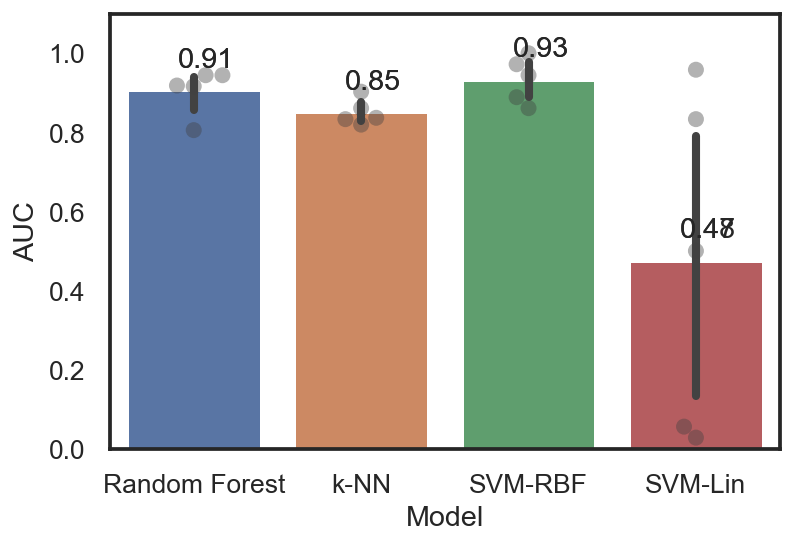

In [230]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');
#plt.savefig('AUC_NMRmodel.svg', dpi=300)

**Accuracy**

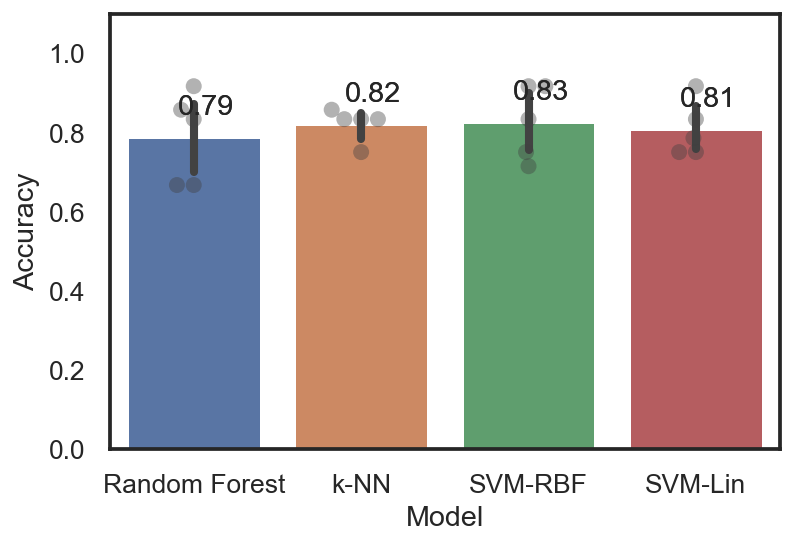

In [231]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');
#plt.savefig('ACC_NMRmodel.svg', dpi=300)

**Precision**

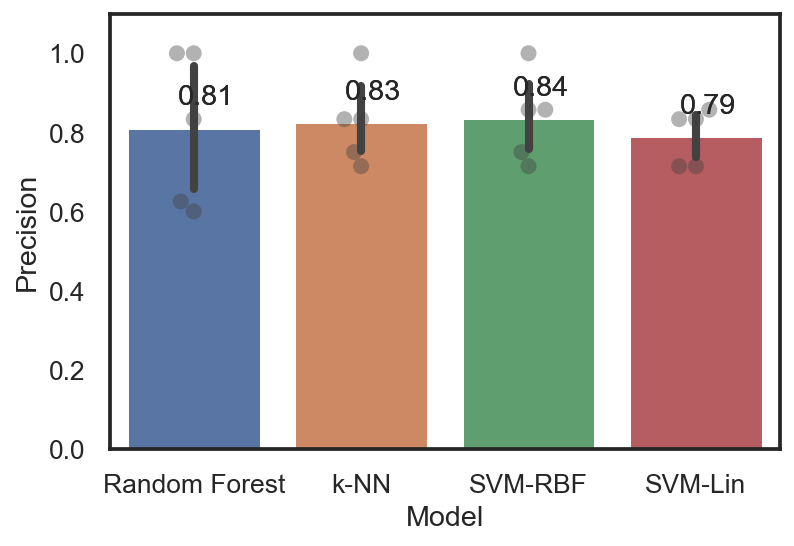

In [232]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');
#plt.savefig('PRE_NMRmodel.svg', dpi=300)

**Recall**

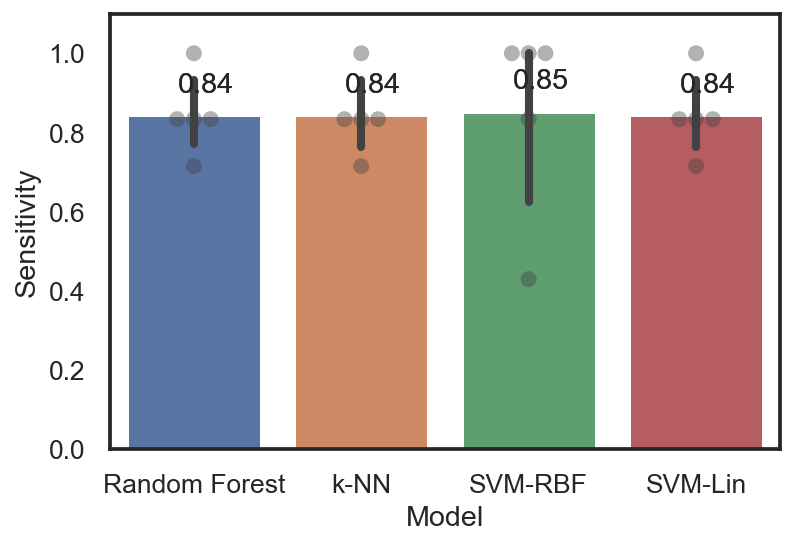

In [233]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Recall Comparison for RCC prediction');
#plt.savefig('SEN_NMRmodel.svg', dpi=300)

**F1 Score**

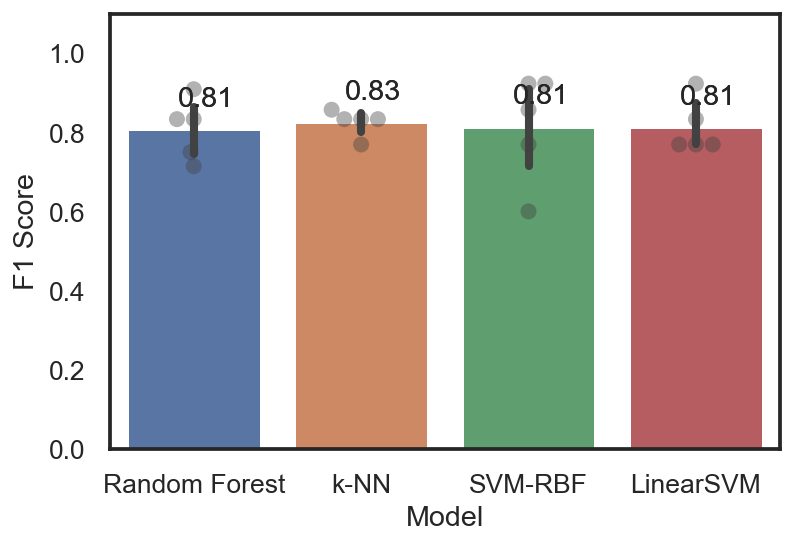

In [234]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('F1_NMRmodel.svg', dpi=300)

**Specificity**

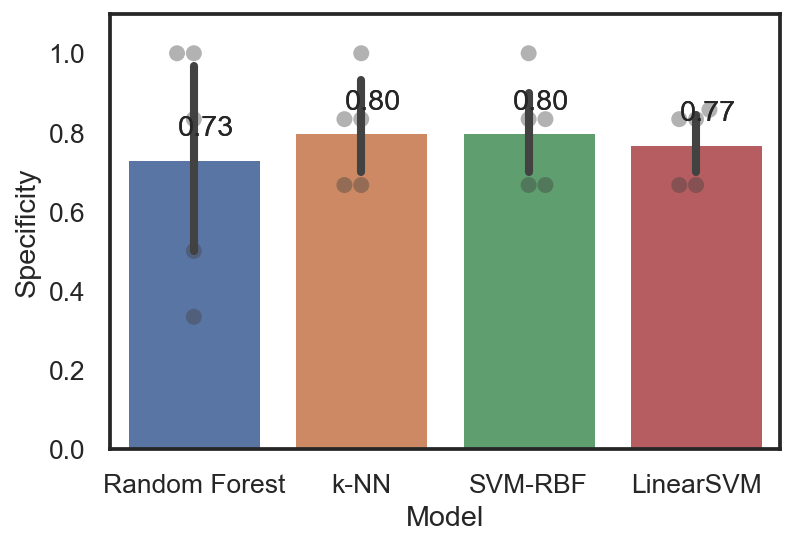

In [235]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('SPE_NMRmodel.svg', dpi=300)

### Chemical Information of the Biomarkers

import NMR ppm dataframe

In [236]:
# Import MS_labels
#MS_labels = pd.read_excel('data/MS_labels.xlsx')

An alternative way to plot the feature importance/

feature_imp = pd.DataFrame({'Features': MLfeatures.columns, 
                           'Importance': RF.feature_importances_})
feature_imp.sort_values(by='Importance', ascending=True, inplace=True);
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp['Features'], 
            y=feature_imp['Importance']);

In [237]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


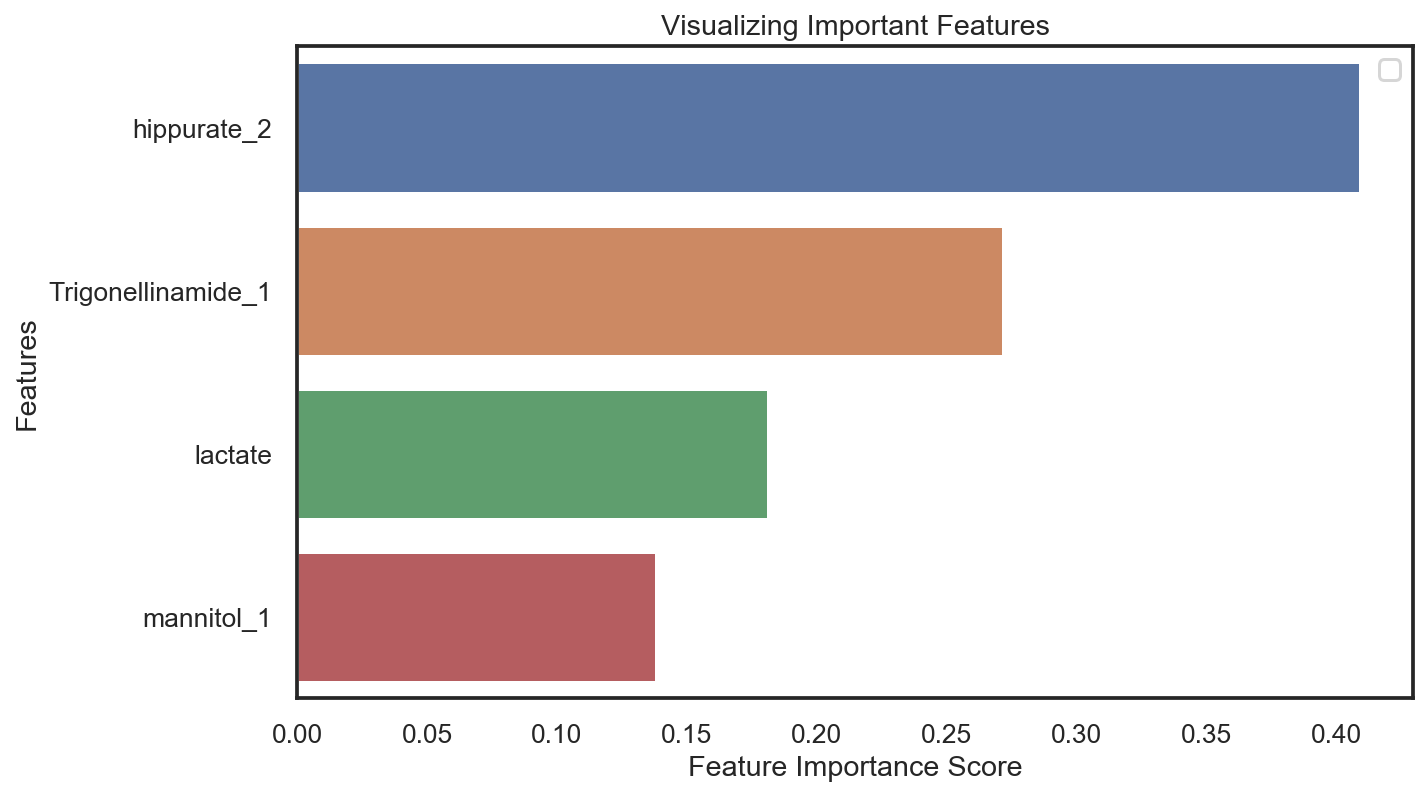

In [238]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### d. Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [239]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = NMR_modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  NMR_modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

_Rename column in biomarker dataframe to reduce length of feature name_

In [241]:
#biomarker.rename(columns={'hippurate_3':'hippuric acid',
#                          'Trigonellinamide_2':'trigonellinamide',
#                          'mannitol_1':'mannitol'}, inplace=True)

**p and q values associated with the metabolite panel in the model cohort**

In [242]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

,Metabolite,T-test p-value,FDR p-value,Reject H0
33,hippurate_2,0.000203,0.002616,True
43,Trigonellinamide_1,0.000281,0.002693,True
5,lactate,0.000494,0.003387,True
23,mannitol_1,0.002882,0.012576,True


#### Boxplot

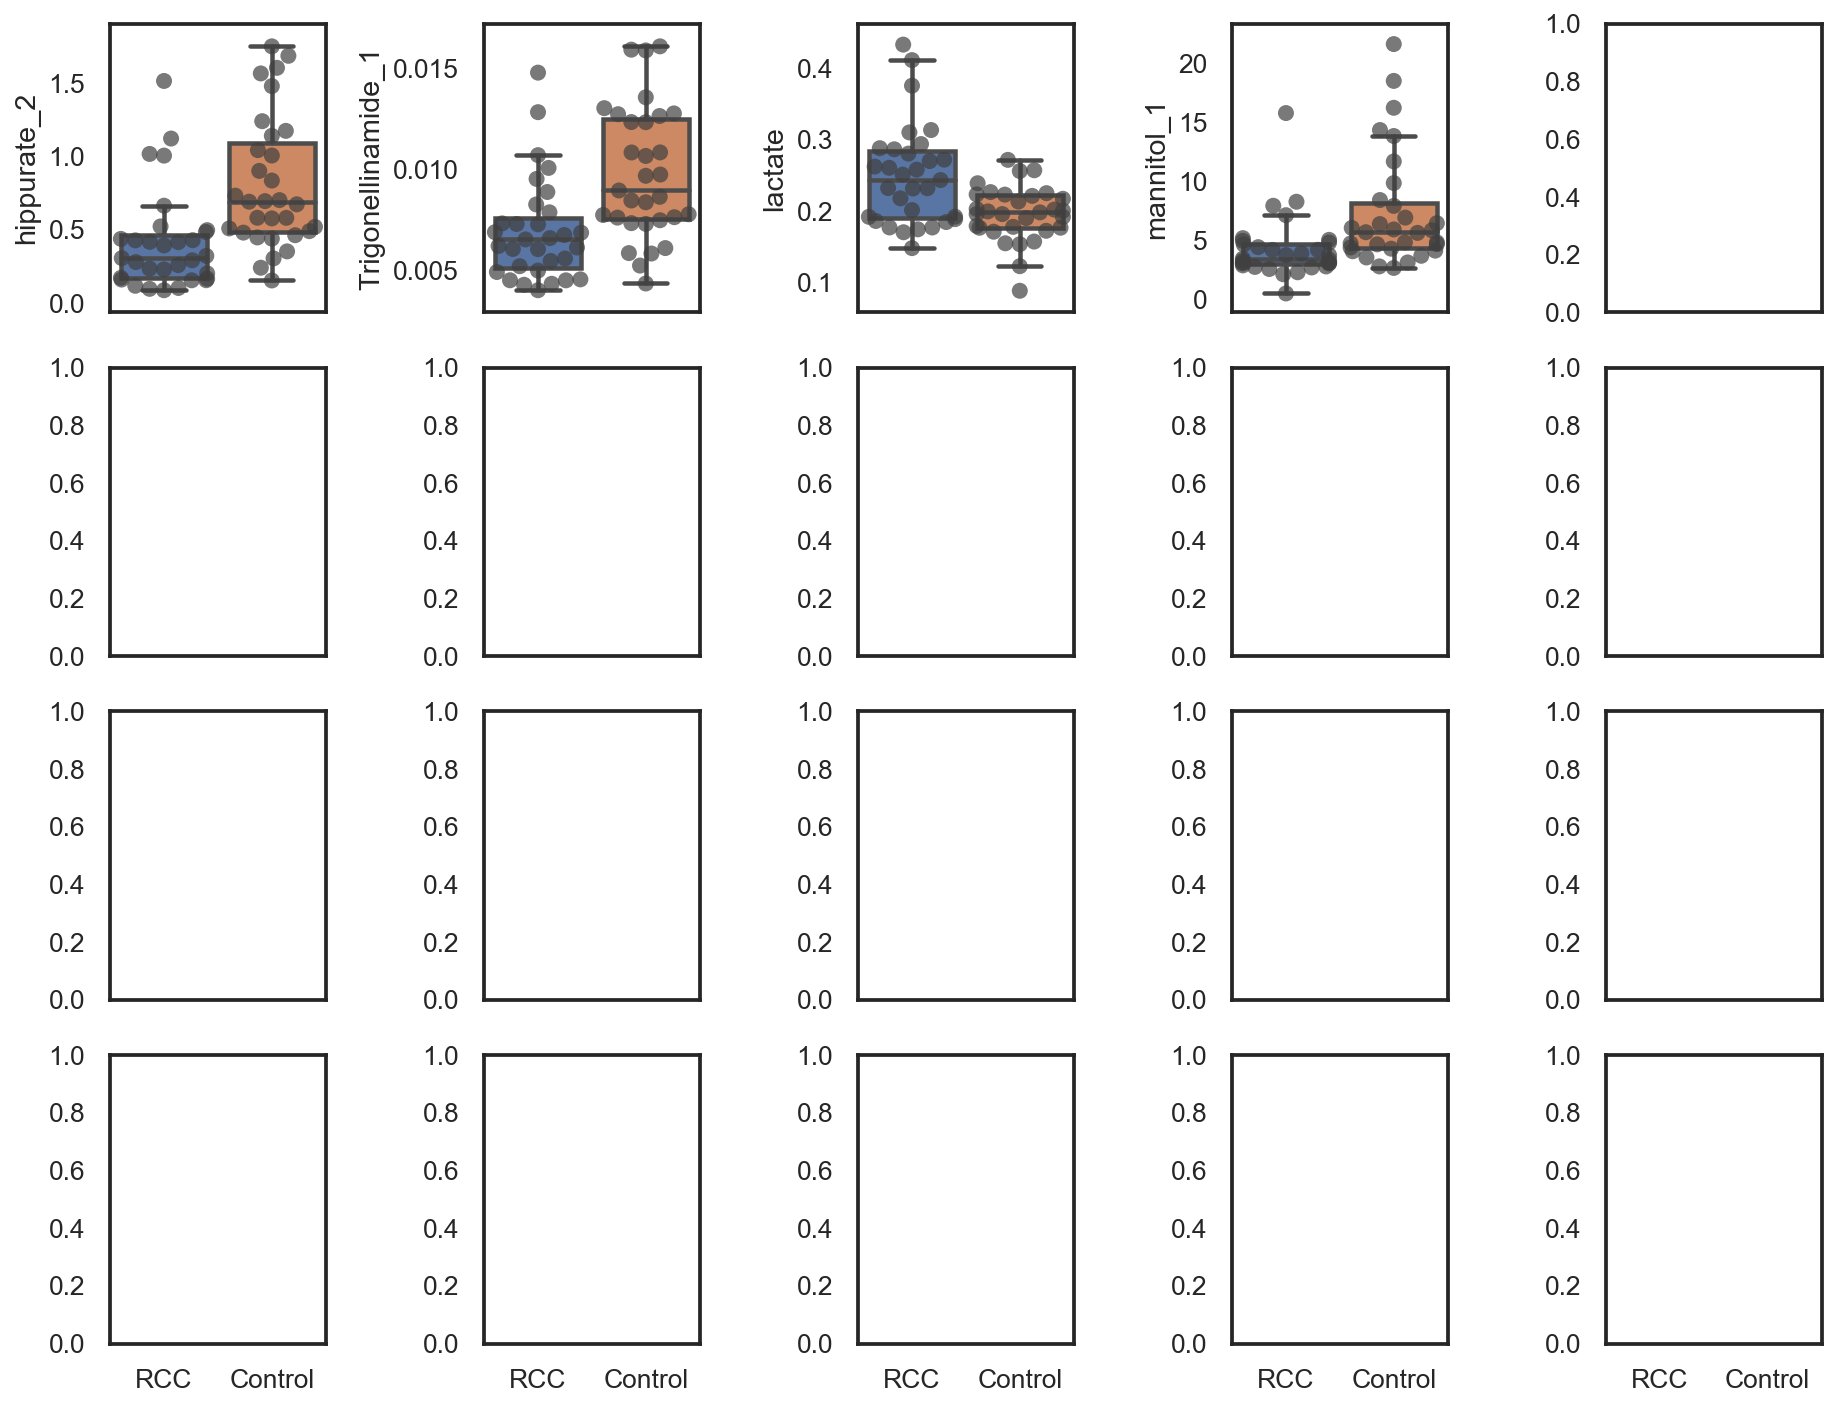

In [306]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(13, 10))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('RQ_NMRmodel.svg', dpi=300)

#### PCA

In [244]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

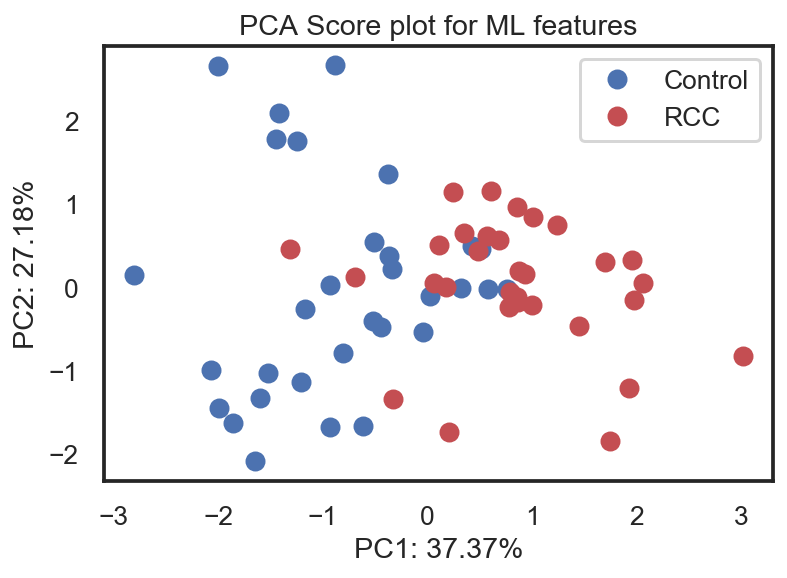

In [311]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures_scaled, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [246]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

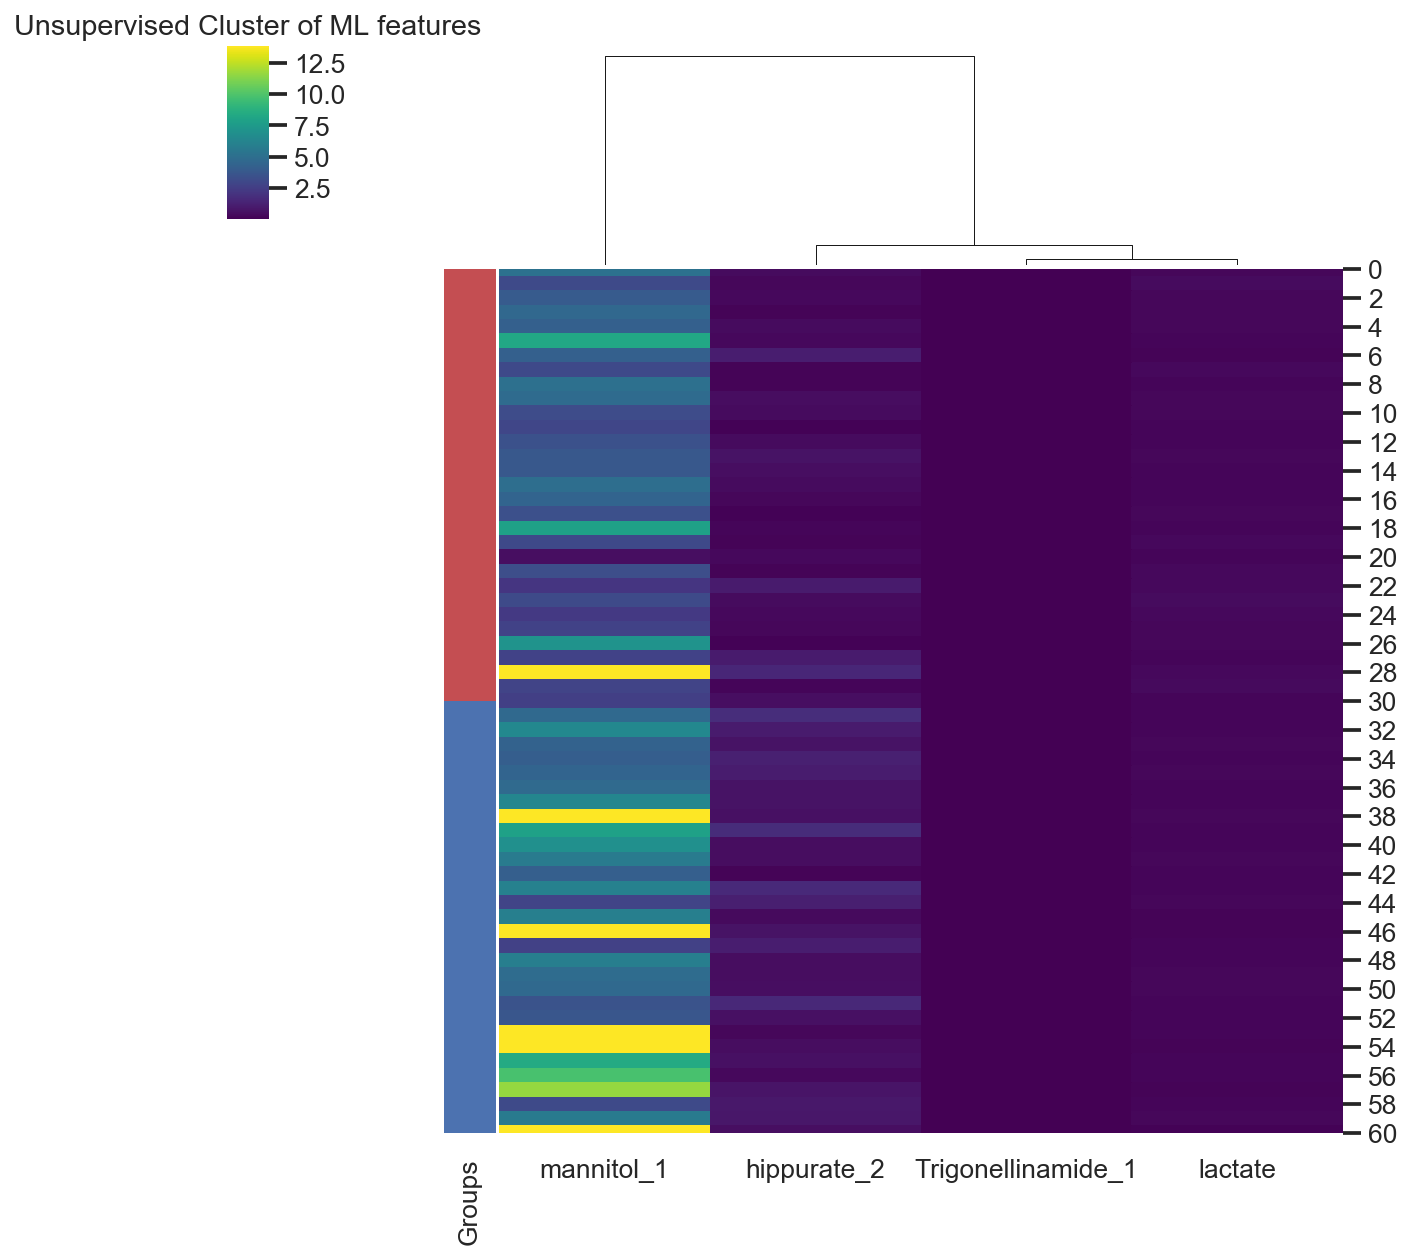

In [247]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [83]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)
print ('The total number of features in this DF is:', len(Feature))

NameError: name 'NMRMS' is not defined

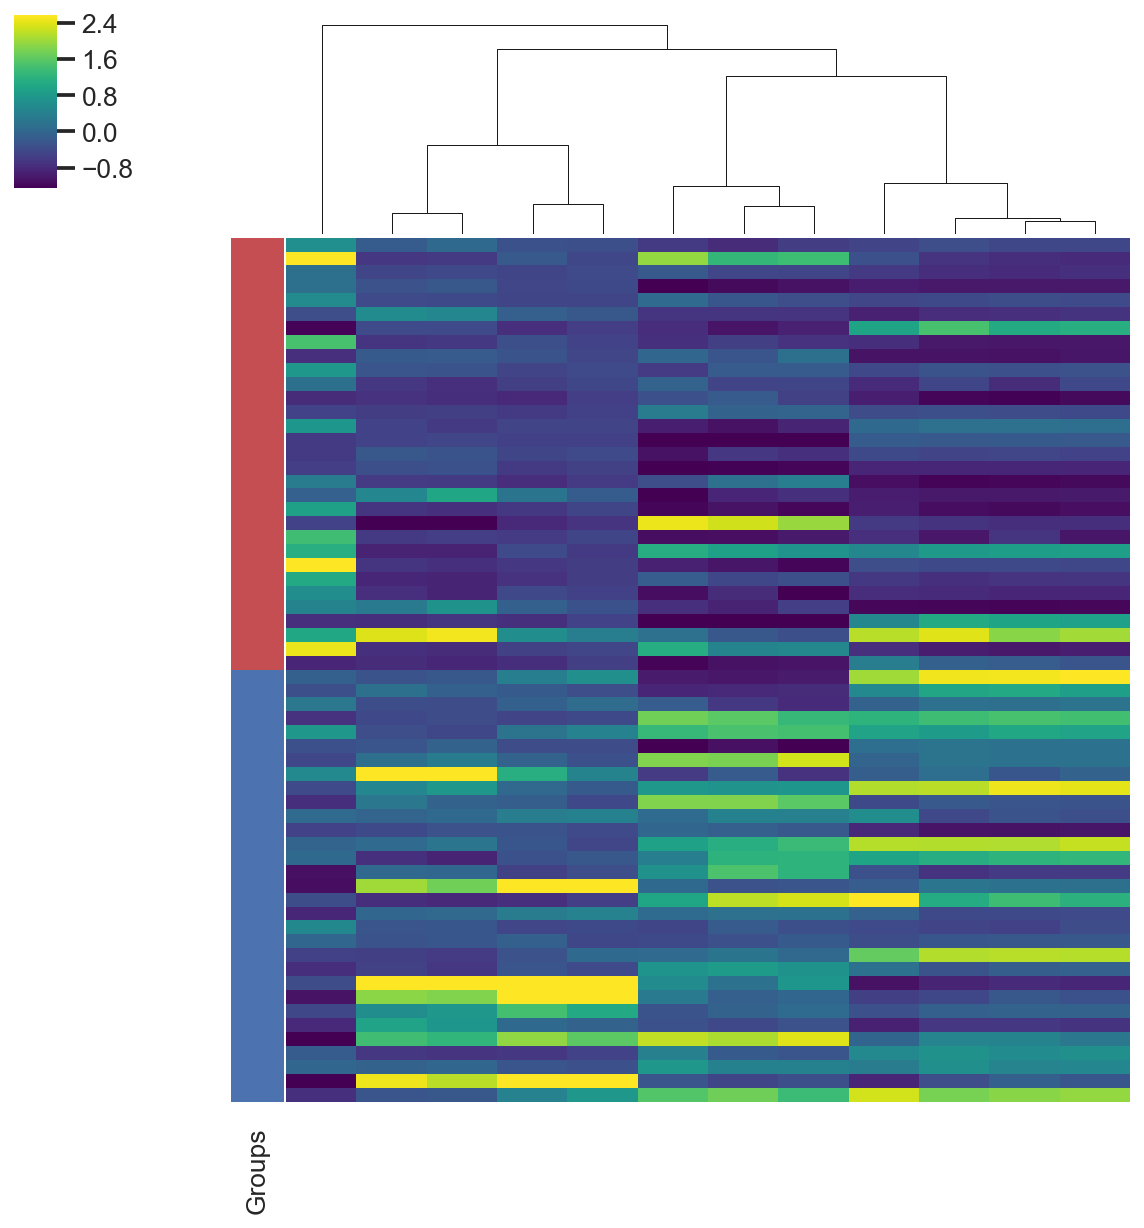

In [429]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
hca_qmarker = sns.clustermap(qmarker, method="weighted", 
               metric='euclidean', cmap="viridis", 
               row_cluster=False, row_colors=row_colors, 
               robust=True, xticklabels=False, 
               yticklabels=False);
#plt.title('Unsupervised Cluster of ML features');

#save figure
#hca_qmarker.savefig("hca_qmarker.svg")
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)


### [Go back to notebook content](#0)

# 2. RCC Prediction: Test Cohort
<a id="2"></a>

In [293]:
testcohort = pd.read_excel('data/testcohort.xlsx')

In [294]:
NMR_testcohort = testcohort.iloc[:,7105:]
NMR_testcohort.columns

Index(['Groups', 'unk1', 'unk2', 'bile_acid1', 'bile_acid2', 'HIVA', 'lactate',
       'unk3', 'acetate', 'acetone', 'unk4', 'acetoacetate', 'unk5',
       'pyruvate', 'citrate', 'DMA', 'unk6', 'methylguanidine', 'unk7',
       'choline', 'scylloinositol', 'taurine', 'acetoacetate_4HPA', 'glycine',
       'mannitol_1', 'mannitol_2', 'creatine', 'glycolate',
       'hippurate_hydroxyhippurate', 'Tatrate', 'unk8', 'unk9', 'fumarate',
       '4HPA', 'hippurate_2', 'hippurate_3', 'aminohippurate',
       'indoxylsulfate', 'hippurate_4', 'hypoxanthine_1', 'hypoxanthine_2',
       'formate', 'unk10', 'Trigonelline_1', 'Trigonellinamide_1',
       'Trigonellinamide_2', 'Trigonelline_2', 'Trigonellinamide_3', 'unk11',
       '_merge'],
      dtype='object')

In [295]:
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2_scaled =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 4)

Define features and labels.

In [296]:
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2_scaled.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 4)
(194,)


### Call the tuned machine learning algorithms

In [269]:
RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [270]:
linsvm

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [271]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [272]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

In [273]:
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Linear-SVM
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

**AUC**

In [274]:
sns.set_context('talk', font_scale=0.8)

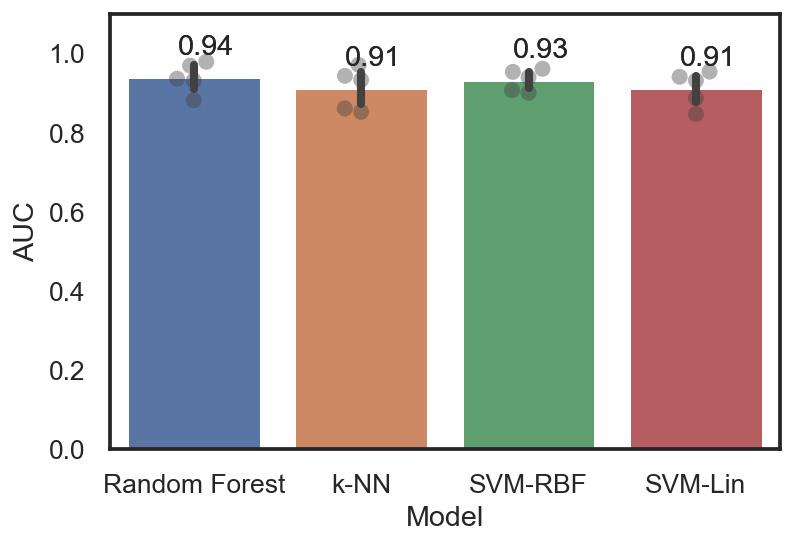

In [275]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');
#plt.savefig('AUC_NMRtest.svg', dpi=300)

**Accuracy**

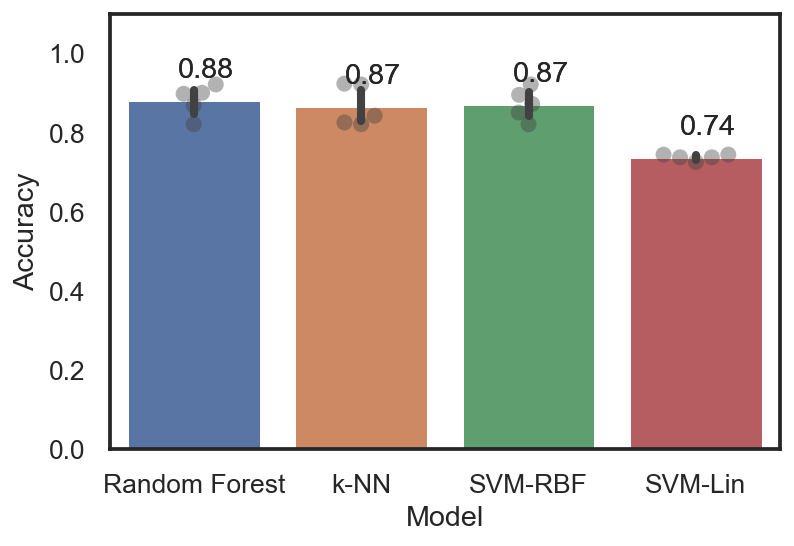

In [276]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');
#plt.savefig('ACC_NMRtest.svg', dpi=300)

**Precision**

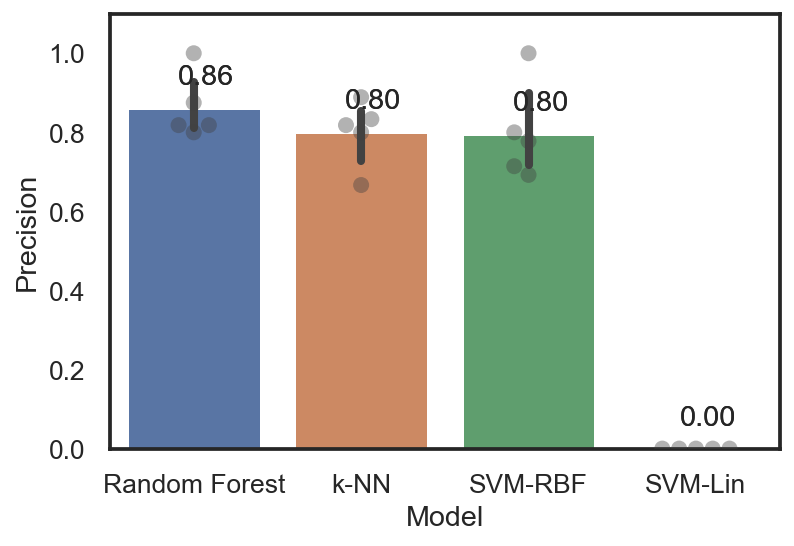

In [277]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Precision Comparison for RCC prediction');
#plt.savefig('PRE_NMRtest.svg', dpi=300)

**Recall**

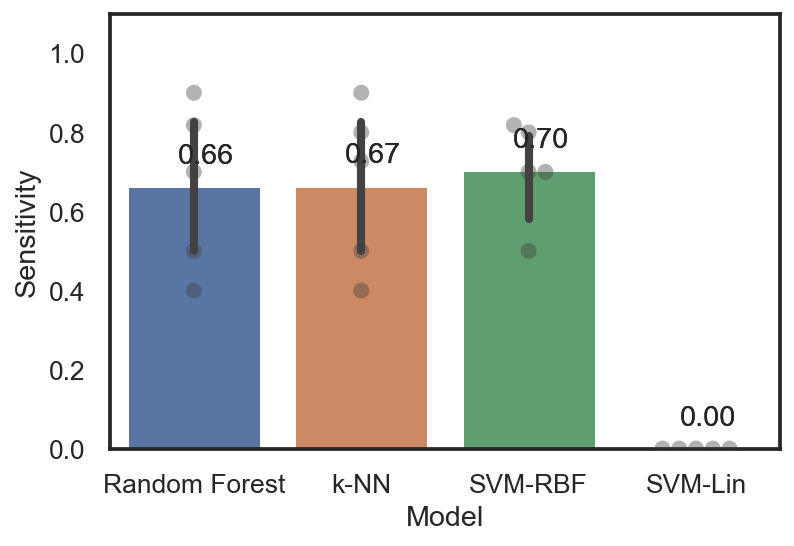

In [278]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Recall Comparison for RCC prediction');
#plt.savefig('SEN_NMRtest.svg', dpi=300)

**F1 Score**

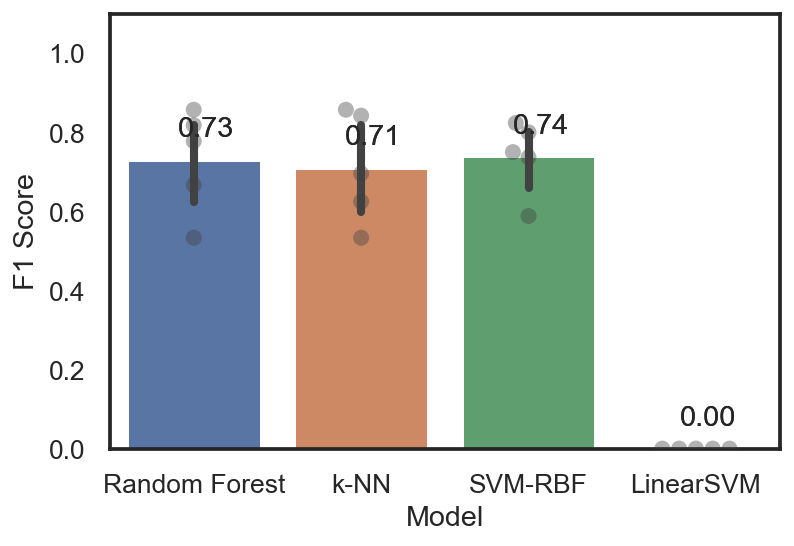

In [279]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('F1_NMRtest.svg', dpi=300)

**Specificity**

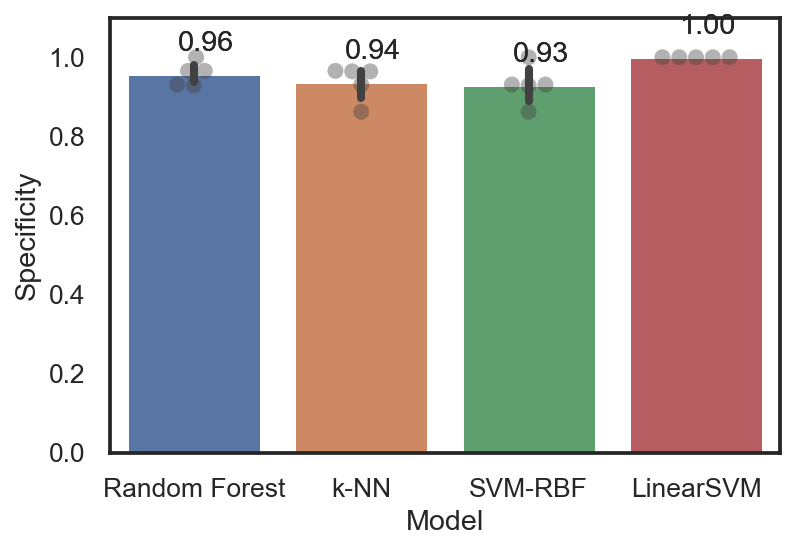

In [280]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('SPE_NMRtest.svg', dpi=300)

The best classifier is RF, and here are the feature importance from random forest:

In [281]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


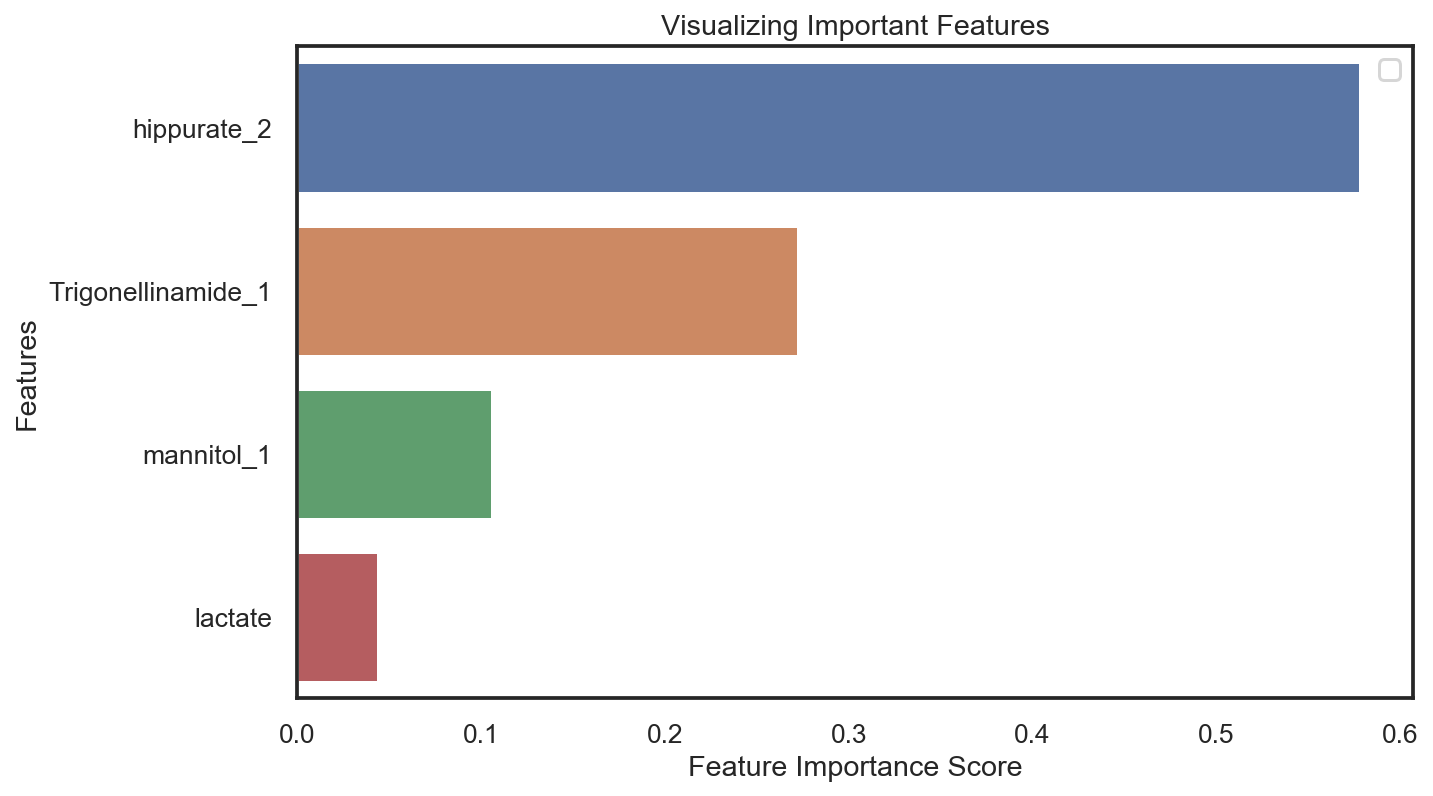

In [282]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [297]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 4)


In [299]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 5)

**_T_-test for metabolic features in the test cohort**

In [300]:
# Select the metabolic feature panel for RCC
MLfeatures2 = NMR_testcohort[biomarker2.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = NMR_testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  NMR_testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [113]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [301]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

,Metabolite,T-test p-value,FDR p-value,Reject H0
0,hippurate_2,1.438252e-13,3.064589e-13,True
1,Trigonellinamide_1,1.532294e-13,3.064589e-13,True
2,lactate,1.114930e-01,1.114930e-01,False
3,mannitol_1,9.147779e-02,1.114930e-01,False


Boxplot

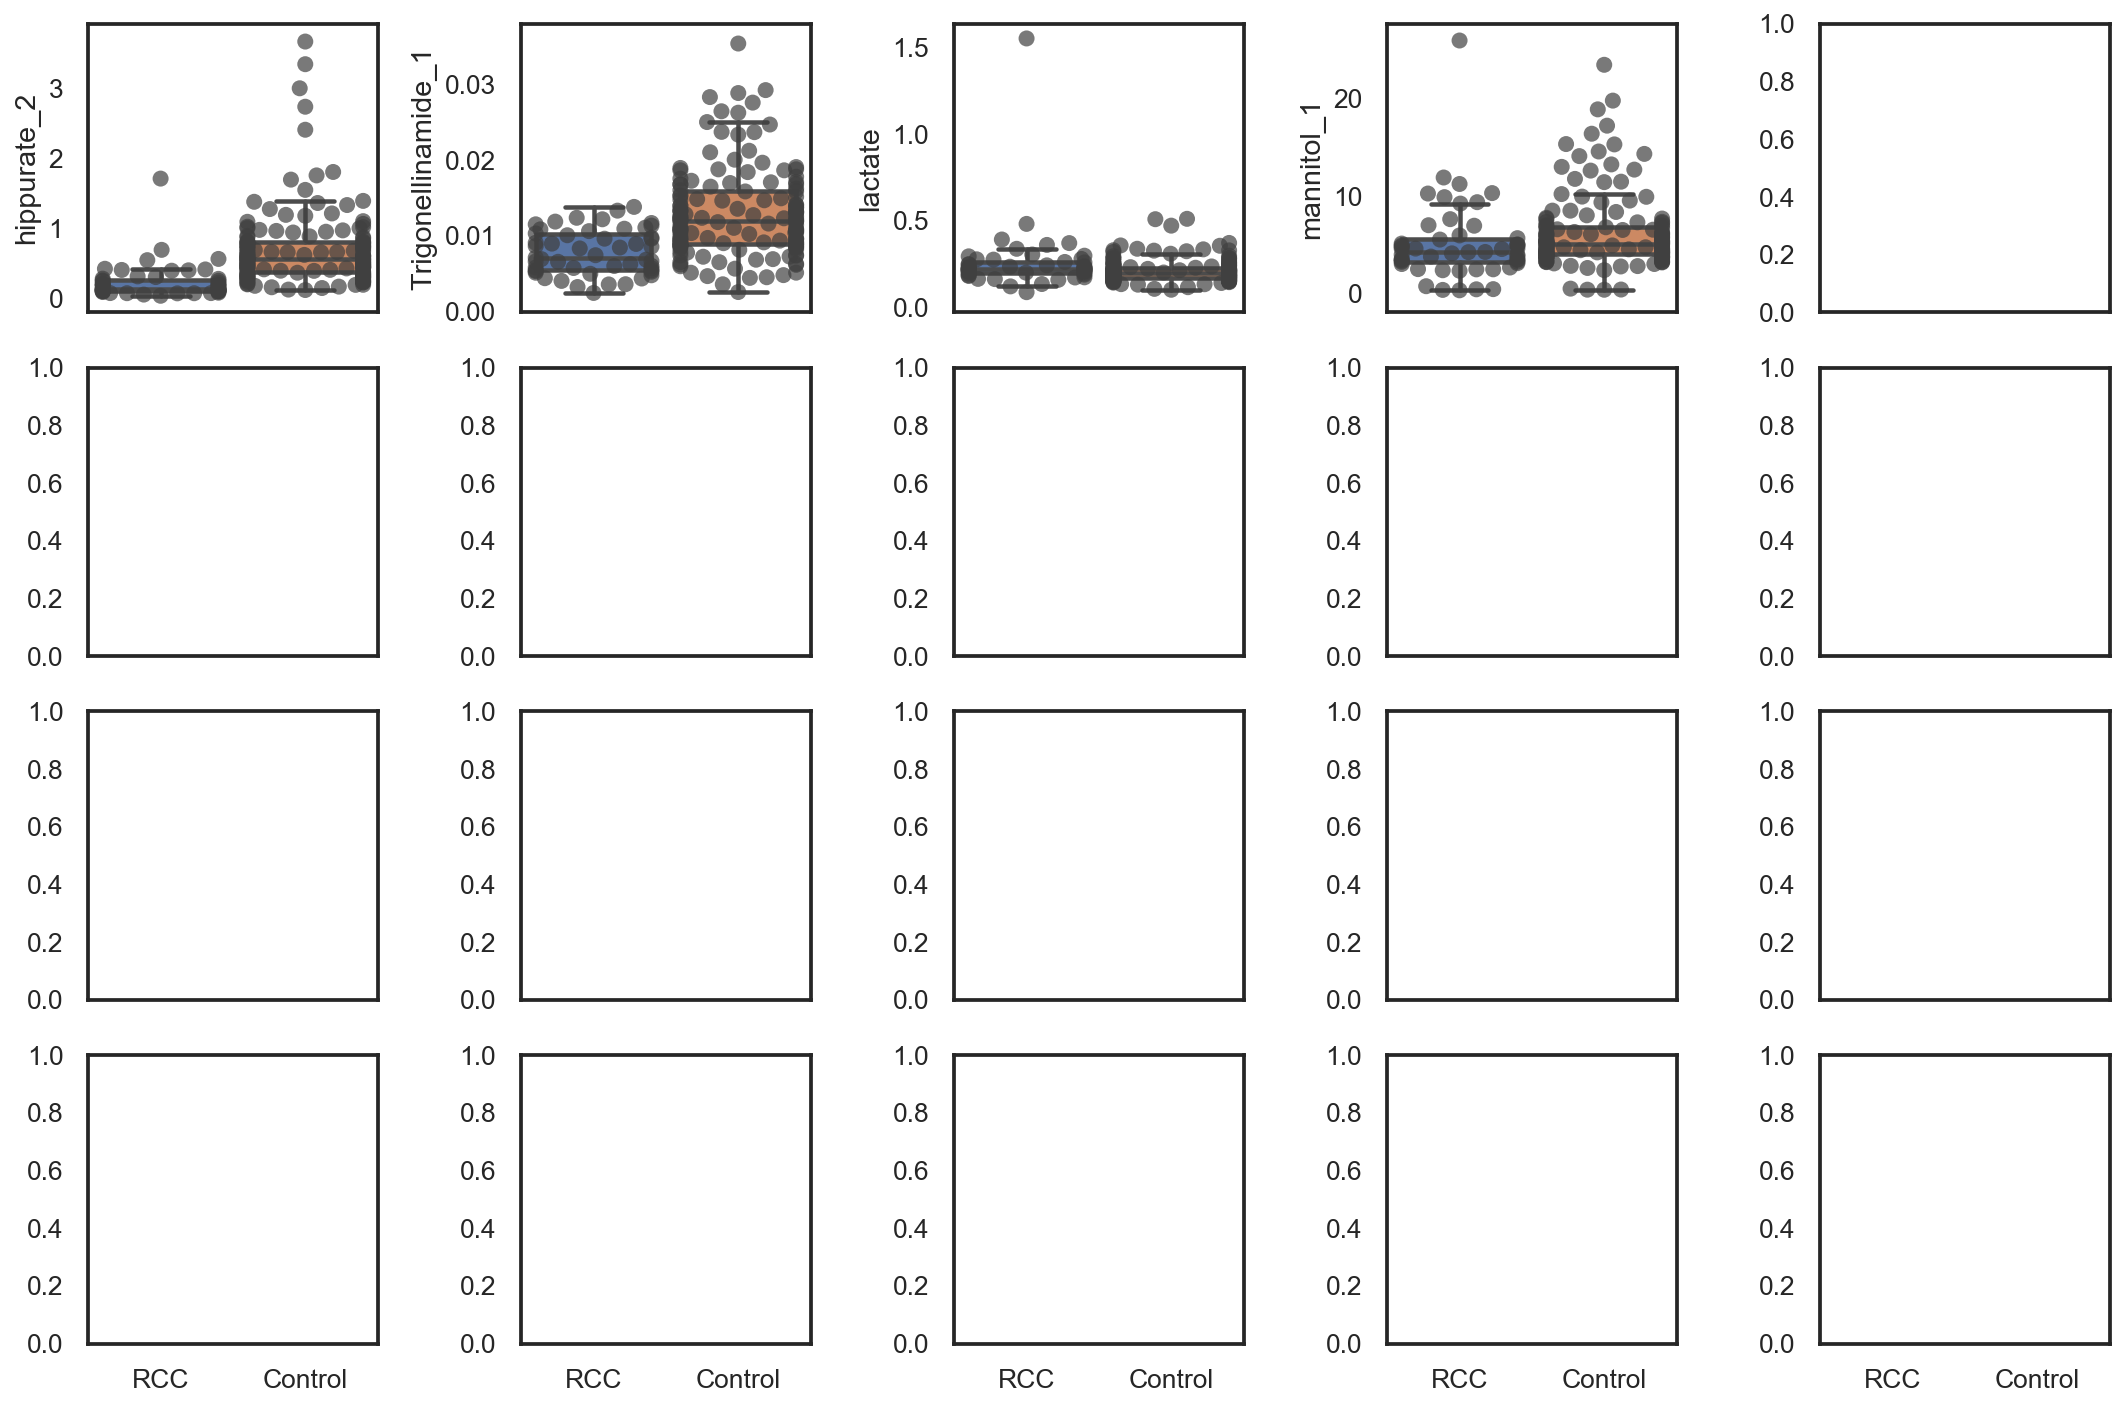

In [307]:
# Select the metabolic feature panel for RCC
MLfeatures2 = NMR_testcohort[biomarker2.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = NMR_testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  NMR_testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)


# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(15, 10))
for idx, feat in enumerate(biomarker_TC.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker_TC, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('RQ_NMRtest.svg', dpi=300)

**PCA score plots using all ML features**

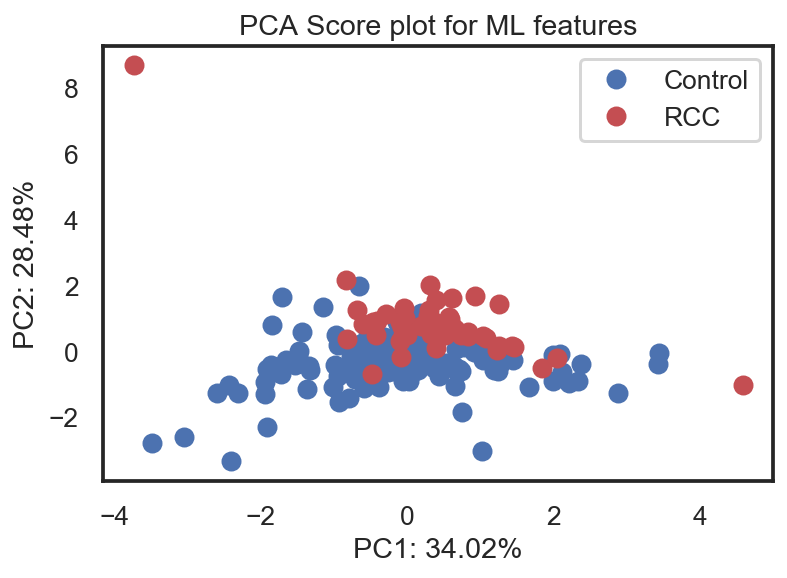

In [310]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures2_scaled, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [453]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 5)

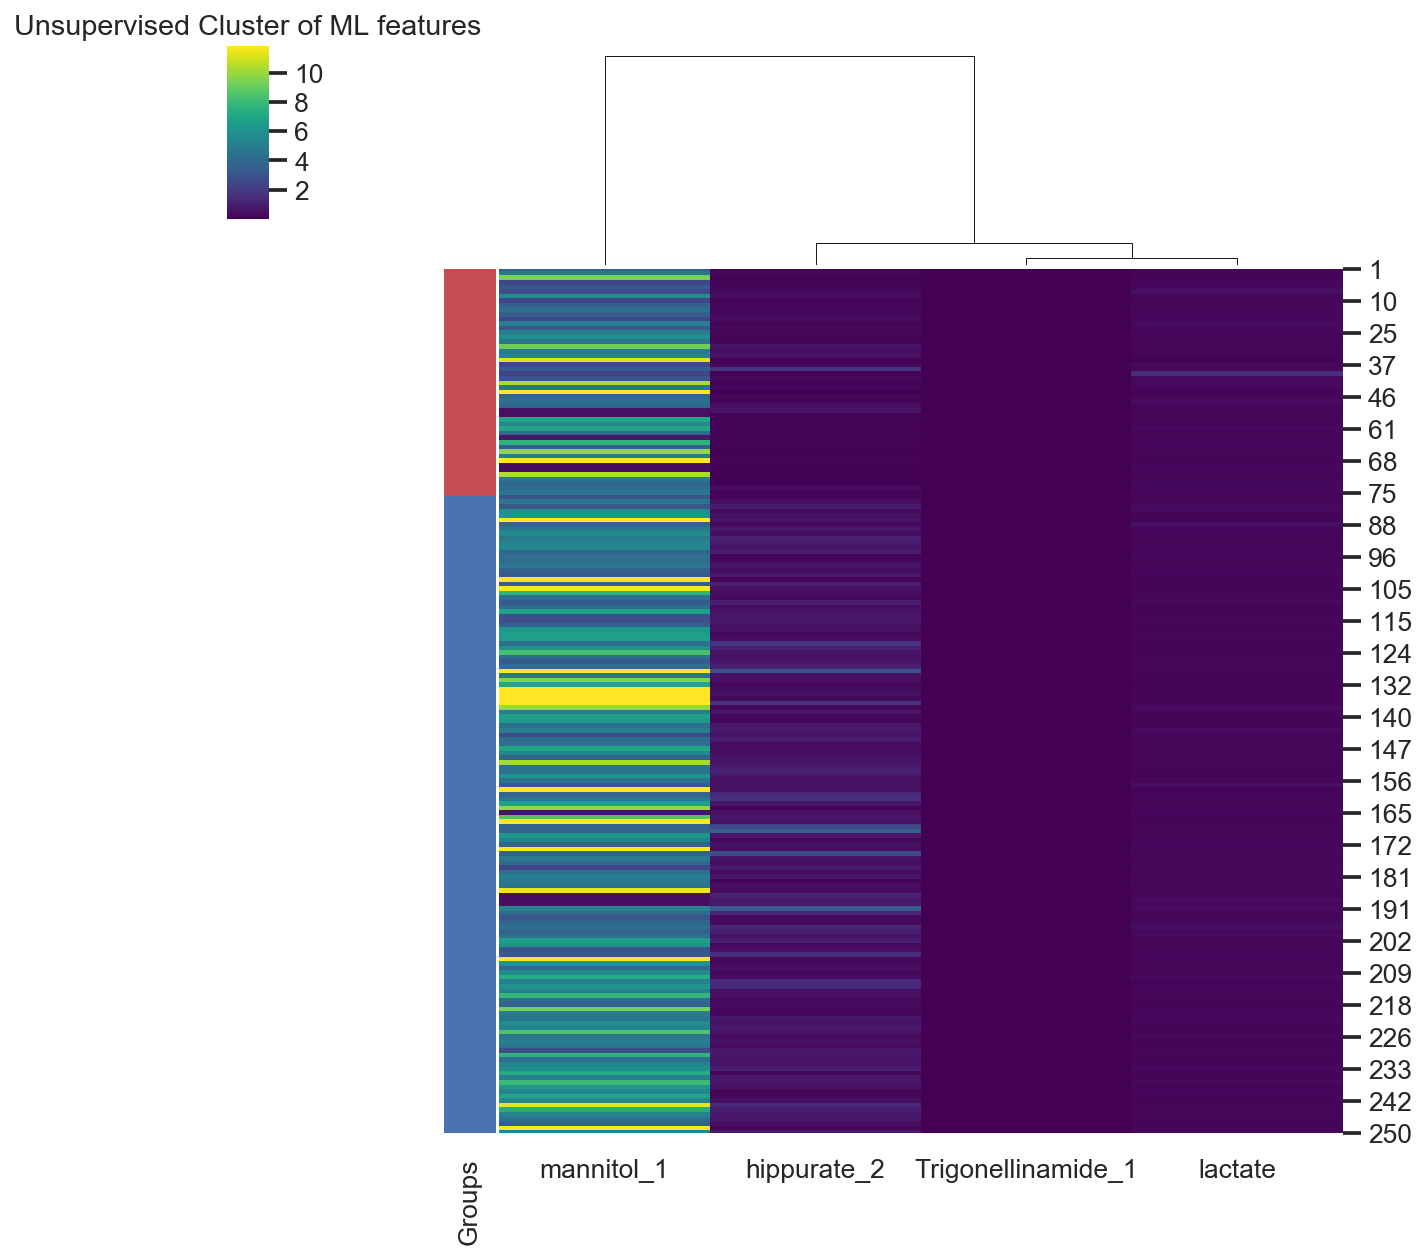

In [454]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

### [Go back to notebook content](#0)